In [1]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps 

#定义一些超参
train_batch_size = 32        #训练时batch_size
train_number_epochs = 50     #训练的epoch

def imshow(img,text=None,should_save=False): 
    #展示一幅tensor图像，输入是(C,H,W)
    npimg = img.numpy() #将tensor转为ndarray
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #转换为(H,W,C)
    plt.show()    

def show_plot(iteration,loss):
    #绘制损失变化图
    plt.plot(iteration,loss)
    plt.show()

In [2]:
#ORL人脸数据集共包含40个不同人的400张图像，此数据集下包含40个目录，每个目录下有10张图像，每个目录表示一个人。
#宽度为92，高度为112的灰度图。training文件夹包含37个人物的图像，其余3个人的图像放在testing

# 自定义dataset 和dataloader

In [3]:
#自定义的Dataset需要实现 __ getitem __ 和 __ len __ 函数。每次读取一对图像，标签表示差异度，0表示同一个人，1表示不是同一人。

In [4]:
#自定义Dataset类，__getitem__(self,index)每次返回(img1, img2, 0/1)
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs) #37个类别中任选一个,随机生成1~37的一个数
        #print(img0_tuple)  ('./data/faces/training/s26\\10.pgm', 18)
        should_get_same_class = random.randint(0,1) #保证同类样本约占一半,随机产生0或1
        if should_get_same_class:   #找同类的文件夹地址
            while True:
                #直到找到同一类别
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:    #找不同类的文件夹地址
                #直到找到非同一类别
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        
        img0 = Image.open(img0_tuple[0])  
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")  #convert:用于不同模式图像之间的转换,L为灰度图，RGB=》L：L = R * 0.299 + G * 0.587+ B * 0.114
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)   #invert：图片取反
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:  #图片转换
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        #返回 两个图片 和 0或1表示两张图片是否同类
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self): 
        return len(self.imageFolderDataset.imgs)  #370
    
    
    
#定义文件dataset
training_dir = "D:/数据库/faces/training/"  #训练集地址
folder_dataset = torchvision.datasets.ImageFolder(root=training_dir)  #载入自己的数据集



#定义图像转换方式
transform = transforms.Compose([transforms.Resize((100,100)), #有坑，传入int和tuple有区别
                                transforms.ToTensor()])
#定义图像dataset
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transform,
                                        should_invert=False)
#定义图像dataloader
train_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=train_batch_size)

In [6]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 1, 100, 100])

# 可视化数据集

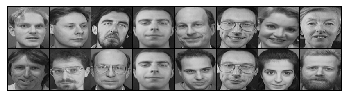

[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [53]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
example_batch = next(iter(vis_dataloader)) #生成一批图像
#其中example_batch[0] 维度为torch.Size([8, 1, 100, 100])
#print(len(example_batch))  3=图片1+图片2+是否同类标签

concatenated = torch.cat((example_batch[0],example_batch[1]),0) 
imshow(torchvision.utils.make_grid(concatenated, nrow=8))
print(example_batch[2].numpy())

# 构建模型

In [8]:
#自定义模型
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),   #padding
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)  #拉直
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    
#自定义损失函数
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [9]:
net = SiameseNetwork().cuda() #定义模型且移至GPU
criterion = ContrastiveLoss() #定义损失函数
optimizer = optim.Adam(net.parameters(), lr = 0.0005) #定义优化器

Epoch number: 0 , Current loss: 0.5631

Epoch number: 1 , Current loss: 0.9247

Epoch number: 2 , Current loss: 0.6787

Epoch number: 3 , Current loss: 0.4403

Epoch number: 4 , Current loss: 0.2333

Epoch number: 5 , Current loss: 0.3800

Epoch number: 6 , Current loss: 0.2113

Epoch number: 7 , Current loss: 0.1861

Epoch number: 8 , Current loss: 0.1599

Epoch number: 9 , Current loss: 0.1377

Epoch number: 10 , Current loss: 0.1492

Epoch number: 11 , Current loss: 0.1493

Epoch number: 12 , Current loss: 0.1600

Epoch number: 13 , Current loss: 0.1416

Epoch number: 14 , Current loss: 0.0777

Epoch number: 15 , Current loss: 0.0393

Epoch number: 16 , Current loss: 0.1021

Epoch number: 17 , Current loss: 0.0473

Epoch number: 18 , Current loss: 0.1008

Epoch number: 19 , Current loss: 0.0642

Epoch number: 20 , Current loss: 0.0319

Epoch number: 21 , Current loss: 0.0814

Epoch number: 22 , Current loss: 0.0456

Epoch number: 23 , Current loss: 0.1029

Epoch number: 24 , Current

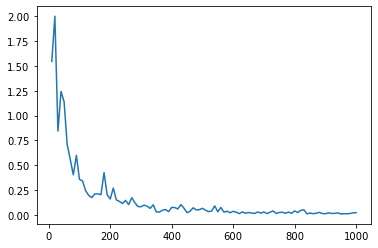

In [55]:
counter = []
loss_history = [] 
iteration_number = 0


#开始训练
for epoch in range(0, train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1 , label = data
        #img0维度为torch.Size([32, 1, 100, 100])，32是batch，label为torch.Size([32, 1])
        img0, img1 , label = img0.cuda(), img1.cuda(), label.cuda() #数据移至GPU
        optimizer.zero_grad()
        output1,output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0 :
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    print("Epoch number: {} , Current loss: {:.4f}\n".format(epoch,loss_contrastive.item()))
    
show_plot(counter, loss_history)